In [68]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
path = "../../data/raw/btsdelay/"
file_list = glob.glob(f"{path}*.parquet")

df = pd.concat([pd.read_parquet(i) for i in file_list])

In [3]:
pd.set_option('display.max_columns', 200)
df.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2018-01-23,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157.0,0.0,-5.0,1256.0,0.0,38.0,62.0,59.0,145.0,2018,1,1,23,2,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8928A,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,14.0,1211.0,1249.0,7.0,1304,-8.0,0.0,-1.0,1300-1359,1,0.0
1,2018-01-24,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157.0,0.0,-5.0,1258.0,0.0,36.0,62.0,61.0,145.0,2018,1,1,24,3,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N800AY,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,13.0,1210.0,1246.0,12.0,1304,-6.0,0.0,-1.0,1300-1359,1,0.0
2,2018-01-25,Endeavor Air Inc.,ABY,ATL,False,False,1202,1153.0,0.0,-9.0,1302.0,0.0,40.0,62.0,69.0,145.0,2018,1,1,25,4,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8836A,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,18.0,1211.0,1251.0,11.0,1304,-2.0,0.0,-1.0,1300-1359,1,0.0
3,2018-01-26,Endeavor Air Inc.,ABY,ATL,False,False,1202,1150.0,0.0,-12.0,1253.0,0.0,35.0,62.0,63.0,145.0,2018,1,1,26,5,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N800AY,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,17.0,1207.0,1242.0,11.0,1304,-11.0,0.0,-1.0,1300-1359,1,0.0
4,2018-01-27,Endeavor Air Inc.,ABY,ATL,False,False,1400,1355.0,0.0,-5.0,1459.0,0.0,36.0,60.0,64.0,145.0,2018,1,1,27,6,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8839E,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1400-1459,17.0,1412.0,1448.0,11.0,1500,-1.0,0.0,-1.0,1500-1559,1,0.0


In [4]:
df['Season'] = np.where(df['Month'].isin([12,1,2]), 'Winter'
                        , np.where(df['Month'].isin([3,4,5]),'Spring'
                           , np.where(df['Month'].isin([6,7,8]),'Summer','Fall')))

Data is from Jan 2018 to July 2022

In [20]:
#Data
reg_data = df[['Origin', 'Month','Airline','DepDelayMinutes','Year']].copy()
reg_data = reg_data[(reg_data['DepDelayMinutes']<1000)]
reg_data['Delay_Ind'] = np.where(reg_data['DepDelayMinutes']> 5,1,0)
reg_data = reg_data.sample(n=1000000, random_state=1234)
feature_cols = ['Origin', 'Month','Airline']

categorical_cols = ['Origin', 'Airline']
numerical_cols = ['Month']
feature_cols = categorical_cols + numerical_cols

In [62]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_cols)],
                                 remainder='passthrough')

rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=10,n_estimators=10,random_state=1234))])

#X_train, X_test, y_train, y_test = train_test_split(X = reg_data[feature_cols], y, test_size=0.25, random_state=1234)

X = reg_data[feature_cols]
y = reg_data['Delay_Ind']

model = rf.fit(X, y)

Random Forest Classifier - Initial Model

In [11]:
# rf = RandomForestClassifier(max_depth=10,n_estimators=10,random_state=1234)
# # Train the model on training data
# model = rf.fit(X_train, y_train);
# #predict_proba

In [70]:
# params = {
#     'max_depth': [2,3,5,10,20],
#     'min_samples_leaf': [5,10,20],
#     'n_estimators': [10,25,30]
# }
param_grid = {
    'preprocessor__cat__onehot__handle_unknown': ['error', 'ignore'],
    'classifier__max_depth': [5, 10, 15,20],
    'classifier__min_samples_leaf': [5,10,20],
    'classifier__n_estimators': [10,25,30]
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=rf,
                          # param_grid=params,
                           param_grid=param_grid,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(X, y)
grid_search.best_score_

Fitting 4 folds for each of 72 candidates, totalling 288 fits


0.753903

In [71]:
rf_best = grid_search.best_estimator_
rf_best

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Origin', 'Airline'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=5,
                                        n_estimators=10, random_state=1234))])

Updated Model with Hyperparameter Tuning

In [72]:
# rf_final = RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=10)
# model_final = rf_final.fit(X_train, y_train);
# predictions_final = model_final.predict_proba(X_test)

rf_final = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=20, min_samples_leaf=5 ,n_estimators=10,random_state=1234))])

model_final = rf_final.fit(X, y)

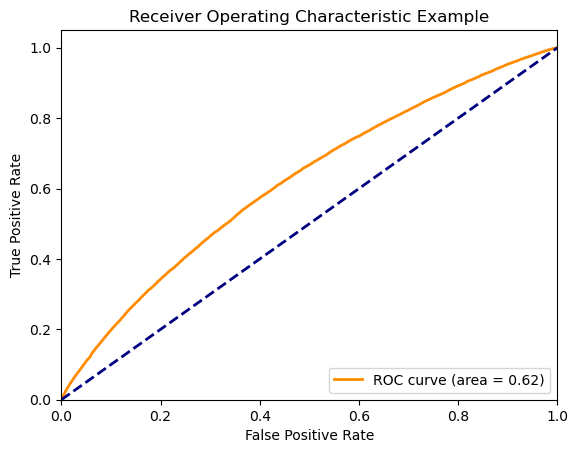

In [34]:
# Test = df[~bad_df]
# # Compute the false positive rate, true positive rate, and threshold
# fpr, tpr, thresholds = roc_curve(y_test, predictions_final[:,1])

# # Compute the area under the curve (AUC) score
# roc_auc = auc(fpr, tpr)

# # Plot the ROC curve
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Example')
# plt.legend(loc="lower right")
# plt.show()

In [75]:
pickle.dump(model_final, open('rf_model.pkl','wb'))

In [76]:
model_open = pickle.load(open('rf_model.pkl','rb'))


# #Example Below
# example_data = pd.DataFrame({'Origin': ['JFK', 'PDX'], 'Month': [12, 12], 'Airline': ['American Airlines Inc.', 'Hawaiian Airlines Inc.']})

# predictions = model_open.predict_proba(example_data)

# print(predictions[0,1])
